In [1]:
import torch

In [69]:
import matplotlib.pyplot as plt

In [73]:
from matplotlib.colors import Normalize

In [158]:
import matplotlib

In [2]:
from PIL import Image

In [3]:
import numpy as np

In [4]:
import cv2

In [5]:
from modeling.maskrcnn_resnet50_fpn import get_model, get_model_attention

In [6]:
from references import transforms as T

In [7]:
from references import utils

In [8]:
from datasets.bird_dataset import BirdDataset

In [9]:
device = torch.device('cuda')
cpu_device = torch.device('cpu')

In [32]:
def get_transform(train):
    transforms = []
    # if train:
        # transforms = [T.RandomColorJitter(), T.RandomGrayscale()]
        # transforms = [T.RandomColorJitter()]
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def get_dataloader():
    dataset = BirdDataset(name="real", transforms=get_transform(False), train=True, small_set=False,
        only_instance=False)
    sampler = torch.utils.data.SequentialSampler(dataset)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1,
        sampler=sampler, num_workers=1,
        collate_fn=utils.collate_fn)
    return dataloader

def get_batch(dataloader, idx=0):
    i = 0
    for images, targets in dataloader:
        if i == idx:
            return list(img.to(device) for img in images), [{k: v.to(device) for k, v in t.items()} for t in targets]
        i += 1

In [33]:
def get_model(resume = "/media/data1/mx_model/bird_detection/bird_detection/ex1_p/model_25.pth"):
    model = get_model_attention(num_classes=4,
        use_focal_loss=True, focal_gamma=0,
        use_attention=False)
    
    checkpoint = torch.load(resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'], strict=False)
    
    model = model.to(device).eval()
    
    return model

In [62]:
def space_decompose(layer, b):
    b_shape = b.shape
    b = b.view(b_shape[0], -1)
    
    A = layer.weight

    A = A.transpose(0, 1)
    b = b.transpose(0, 1)
    x_hat = torch.solve(A.transpose(0, 1) @ b, A.transpose(0, 1) @ A)[0]        
    p = A @ x_hat

    e = b - p

    row_space = p.transpose(0, 1)
    null_space = e.transpose(0, 1)
    
    row_space = row_space.view(b_shape)
    null_space = null_space.view(b_shape)

    return row_space, null_space

In [67]:
def run_model(model, images, targets):
    with torch.no_grad():
        images, targets = model.transform(images, targets)
        features = model.backbone(images.tensors)
        proposals, proposal_losses = model.rpn(images, features, targets)
    
        box_features = model.roi_heads.box_roi_pool(features, [t['boxes'] for t in targets], images.image_sizes)

    return box_features

def get_features(model, dataloader, idx=0):
    images, targets = get_batch(dataloader, idx)
    box_features = run_model(model, images, targets)
    
    box_features_row, box_features_null = space_decompose(model.roi_heads.box_head.fc6, box_features)
    
        
    dataset = dataloader.dataset
    img = Image.open(dataset.imgs_path/dataset.records[idx]['img_name'])
    
    target = targets[0]
    bboxes = dataset.records[idx]['list_bbox']
    
    imgs = []
    labels = []
    features = []
    row_features = []
    null_features = []
    for i, bbox in enumerate(bboxes):
        imgs.append(img.crop(bbox))
        labels.append(dataset.records[idx]['list_label_index'][i])
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        features.append( cv2.resize(box_features[i].mean(0).cpu().detach().numpy(), (w, h)) )
        row_features.append( cv2.resize(box_features_row[i].mean(0).cpu().detach().numpy(), (w, h)) )
        null_features.append( cv2.resize(box_features_null[i].mean(0).cpu().detach().numpy(), (w, h)) )
    
    return imgs, labels, features, row_features, null_features

In [70]:
def get_color_mask(weight, vmin, vmax, cmap=plt.cm.viridis):
    alphas = np.ones(weight.shape)
    alphas[:, :] = 0.7
    colors = Normalize(vmin, vmax)(weight)
    colors = cmap(colors)
    colors[..., -1] = alphas
    
    return colors

In [89]:
def show_step(img, row1, row2, fig, axes, use_title=False, cmap=plt.cm.viridis):
    vmax = max([row1.max(), row2.max()])
    vmin = min([row1.min(), row2.min()])
    
    axes[0].imshow(img)
    
    axes[1].imshow(row1, vmax=vmax, vmin=vmin, cmap=cmap)
    axes[2].imshow(row2, vmax=vmax, vmin=vmin, cmap=cmap)
    
    axes[3].imshow(img)
    axes[3].imshow(get_color_mask(row1, vmin, vmax, cmap=cmap))
    axes[4].imshow(img)
    im = axes[4].imshow(get_color_mask(row2, vmin, vmax, cmap=cmap))
    
    
    p0 = axes[0].get_position().get_points().flatten()
    p1 = axes[-1].get_position().get_points().flatten()
    
    if use_title:
        axes[0].set_title("image")
        axes[1].set_title("baseline")
        axes[2].set_title("domain randomization")
        axes[3].set_title("baseline")
        axes[4].set_title("domain randomization")
    
    return [im, p0, p1]  

In [151]:
def show(imgs, rows1, rows2, cmap=plt.cm.viridis):
    plt.close()
    imgs = [np.array(img) for img in imgs]
    fig, axes = plt.subplots(ncols=5, nrows=len(imgs), figsize=(25, 3 * len(imgs)))
    
    ims = []
    p0s = []
    p1s = []
    if len(imgs) > 1:
        for i in range(len(axes)):
            if i == 0:
                use_title = True
            else:
                use_title = False

            im, p0, p1 = show_step(imgs[i], rows1[i], rows2[i], fig, axes[i], use_title=use_title, cmap=cmap)
            ims.append(im)
            p0s.append(p0)
            p1s.append(p1)
    else:
        im, p0, p1 = show_step(imgs[0], rows1[0], rows2[0], fig, axes, use_title=True, cmap=cmap)
        ims.append(im)
        p0s.append(p0)
        p1s.append(p1)
    
    if len(imgs) > 1:
        for i in range(len(axes)):
            ax_cbar = fig.add_axes([p0s[i][0], p1s[i][1]-0.01, p1s[i][2]-p0s[i][0], 0.005])
            fig.colorbar(ims[i], cax=ax_cbar, orientation='horizontal')
    else:
        ax_cbar = fig.add_axes([p0s[0][0], p1s[0][1]-0.01, p1s[0][2]-p0s[0][0], 0.005])
        fig.colorbar(ims[0], cax=ax_cbar, orientation='horizontal')
    
    if len(imgs) > 1:
        for axes_i in axes:
            for ax in axes_i:
                ax.axis('off')
    else:
        for ax in axes:
            ax.axis('off')
        
    
    
#     vmax = max([feature.max(), row.max(), null.max()])
#     vmin = min([feature.min(), row.min(), null.min()])
    
#     axes[0][0].imshow(img_0)
#     axes[0][1].imshow(feature, vmax=vmax, vmin=vmin, cmap=cmap)
#     axes[0][1].set_title("whole space feature")
#     axes[0][2].imshow(row, vmax=vmax, vmin=vmin, cmap=cmap)
#     axes[0][2].set_title("row subspace feature")
#     im = axes[0][3].imshow(null, vmax=vmax, vmin=vmin, cmap=cmap)
#     axes[0][3].set_title("null subspace feature")
    
#     for ax in axes[1][1:]:
#         ax.imshow(img_0)
    
#     axes[1][1].imshow(get_color_mask(feature, vmin, vmax, cmap=cmap))
#     axes[1][2].imshow(get_color_mask(row, vmin, vmax, cmap=cmap))
#     axes[1][3].imshow(get_color_mask(null, vmin, vmax, cmap=cmap))
    
#     for ax in axes[0]:
#         ax.axis('off')
#     for ax in axes[1]:
#         ax.axis('off')
#     p0 = axes[0][0].get_position().get_points().flatten()
#     p1 = axes[1][-1].get_position().get_points().flatten()
#     ax_cbar = fig.add_axes([p0[0], p1[1]-0.08, p1[2]-p0[0], 0.03])
#     fig.colorbar(im, cax=ax_cbar, orientation='horizontal')
# #     if idx < 0:
# #         idx = f"m{-idx}"
    fig.savefig(f"feature_maps.jpg")
    plt.show()

In [92]:
def main(model1, model2, dataloader, idx=0):
    imgs, _, _, row_features1, _ = get_features(model1, dataloader, idx=idx)
    _, _, _, row_features2, _ = get_features(model2, dataloader, idx=idx)
    show(imgs, row_features1, row_features2, cmap=plt.cm.inferno)

In [87]:
dataloader = get_dataloader()
model_baseline = get_model()
model_syn = get_model("/media/data1/mx_model/bird_detection/bird_detection/ex1ft_p/model_25.pth")

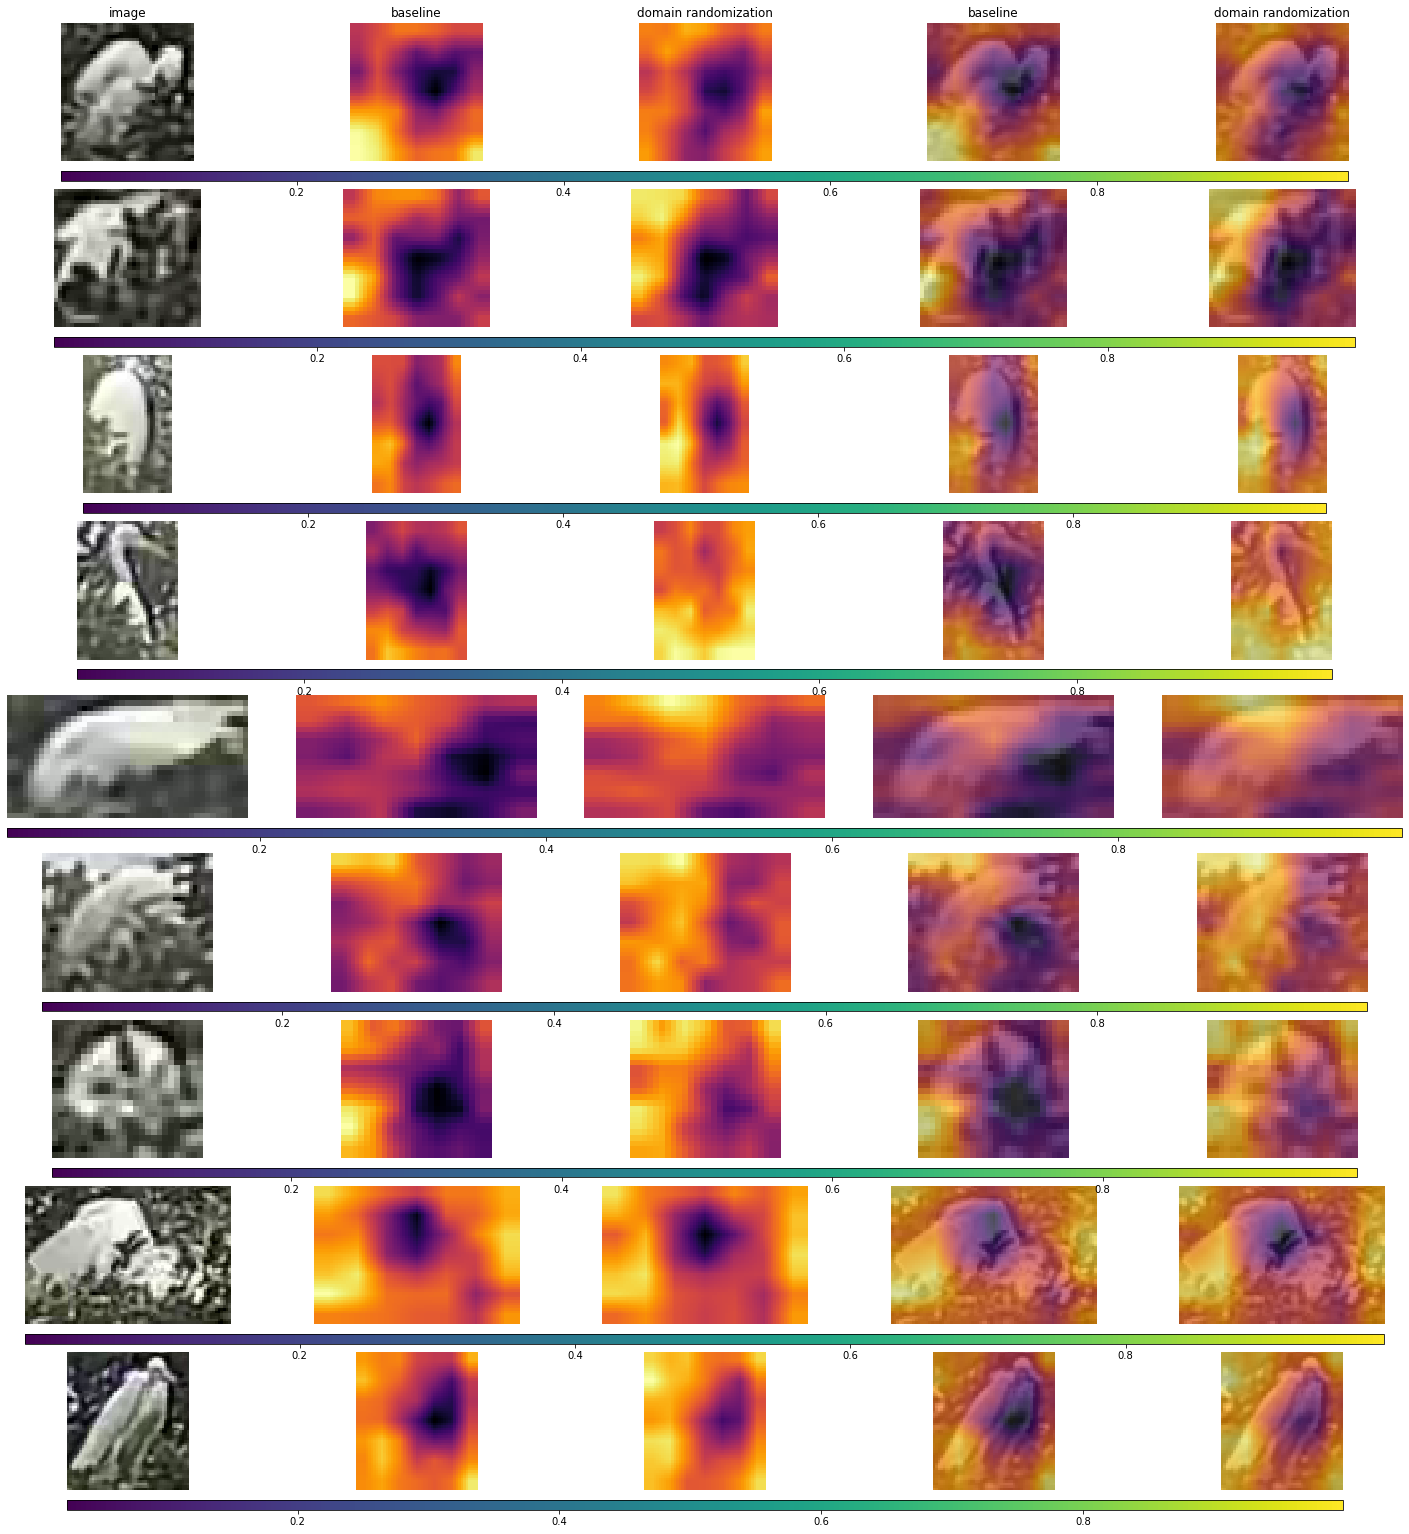

In [145]:
main(model_baseline, model_syn, dataloader, idx=30)

In [155]:
def main1(model1, model2, dataloader, used_dict):
    merged_imgs = []
    merged_rows1 = []
    merged_rows2 = []
    for key, value in used_dict.items():
        imgs, _, _, row_features1, _ = get_features(model1, dataloader, idx=key)
        _, _, _, row_features2, _ = get_features(model2, dataloader, idx=key)
        for i in value:
            merged_imgs.append(imgs[i])
            merged_rows1.append(row_features1[i])
            merged_rows2.append(row_features2[i])
            
    show(merged_imgs, merged_rows1, merged_rows2, cmap=plt.cm.inferno)
    
    return merged_imgs, merged_rows1, merged_rows2

In [147]:
used_dict = {
    0: [0],
    5: [0],
    12: [-1],
    14: [0, -2],
    25: [-1, -2],
    27: [-1],
    28: [0],
    30: [-1],
}

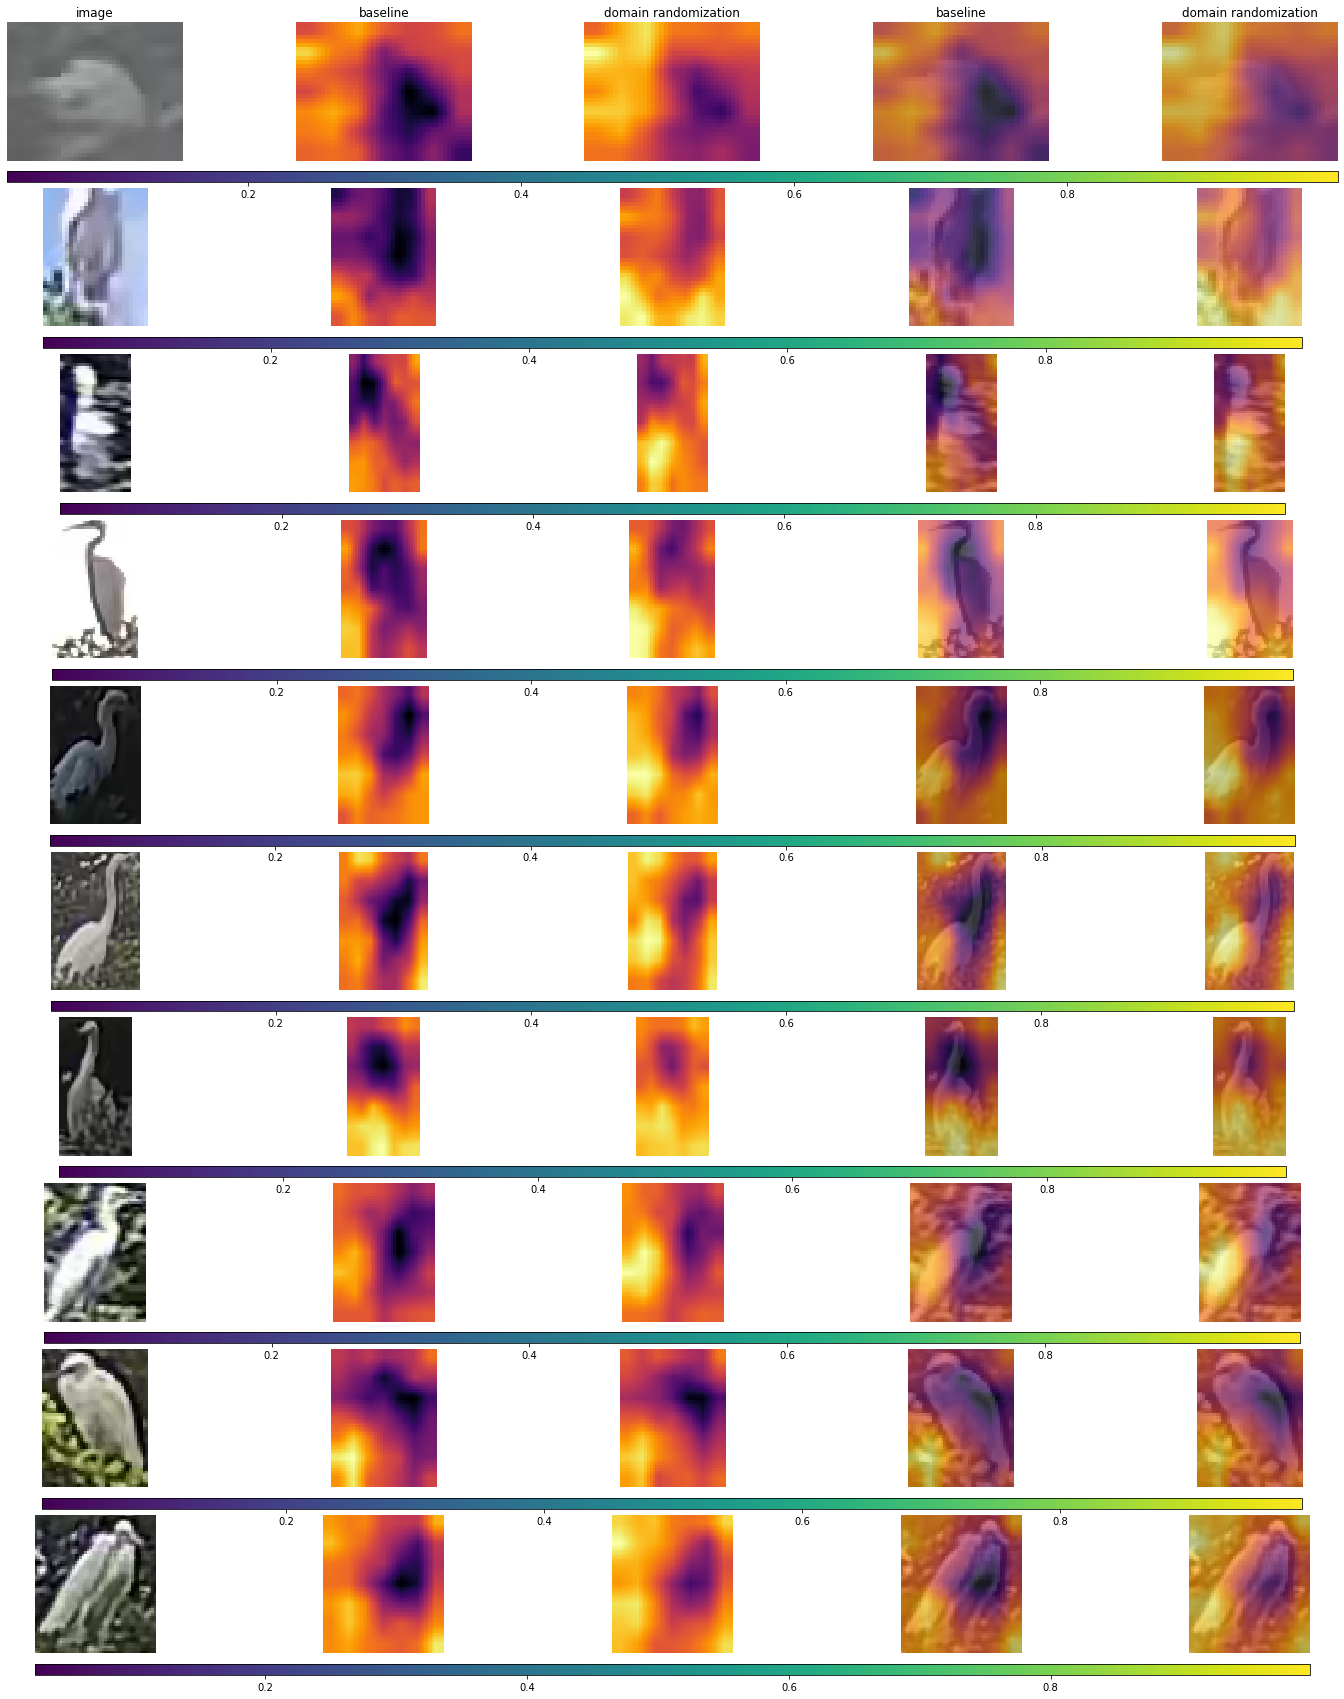

In [156]:
merged_imgs, merged_rows1, merged_rows2 = main1(model_baseline, model_syn, dataloader, used_dict)

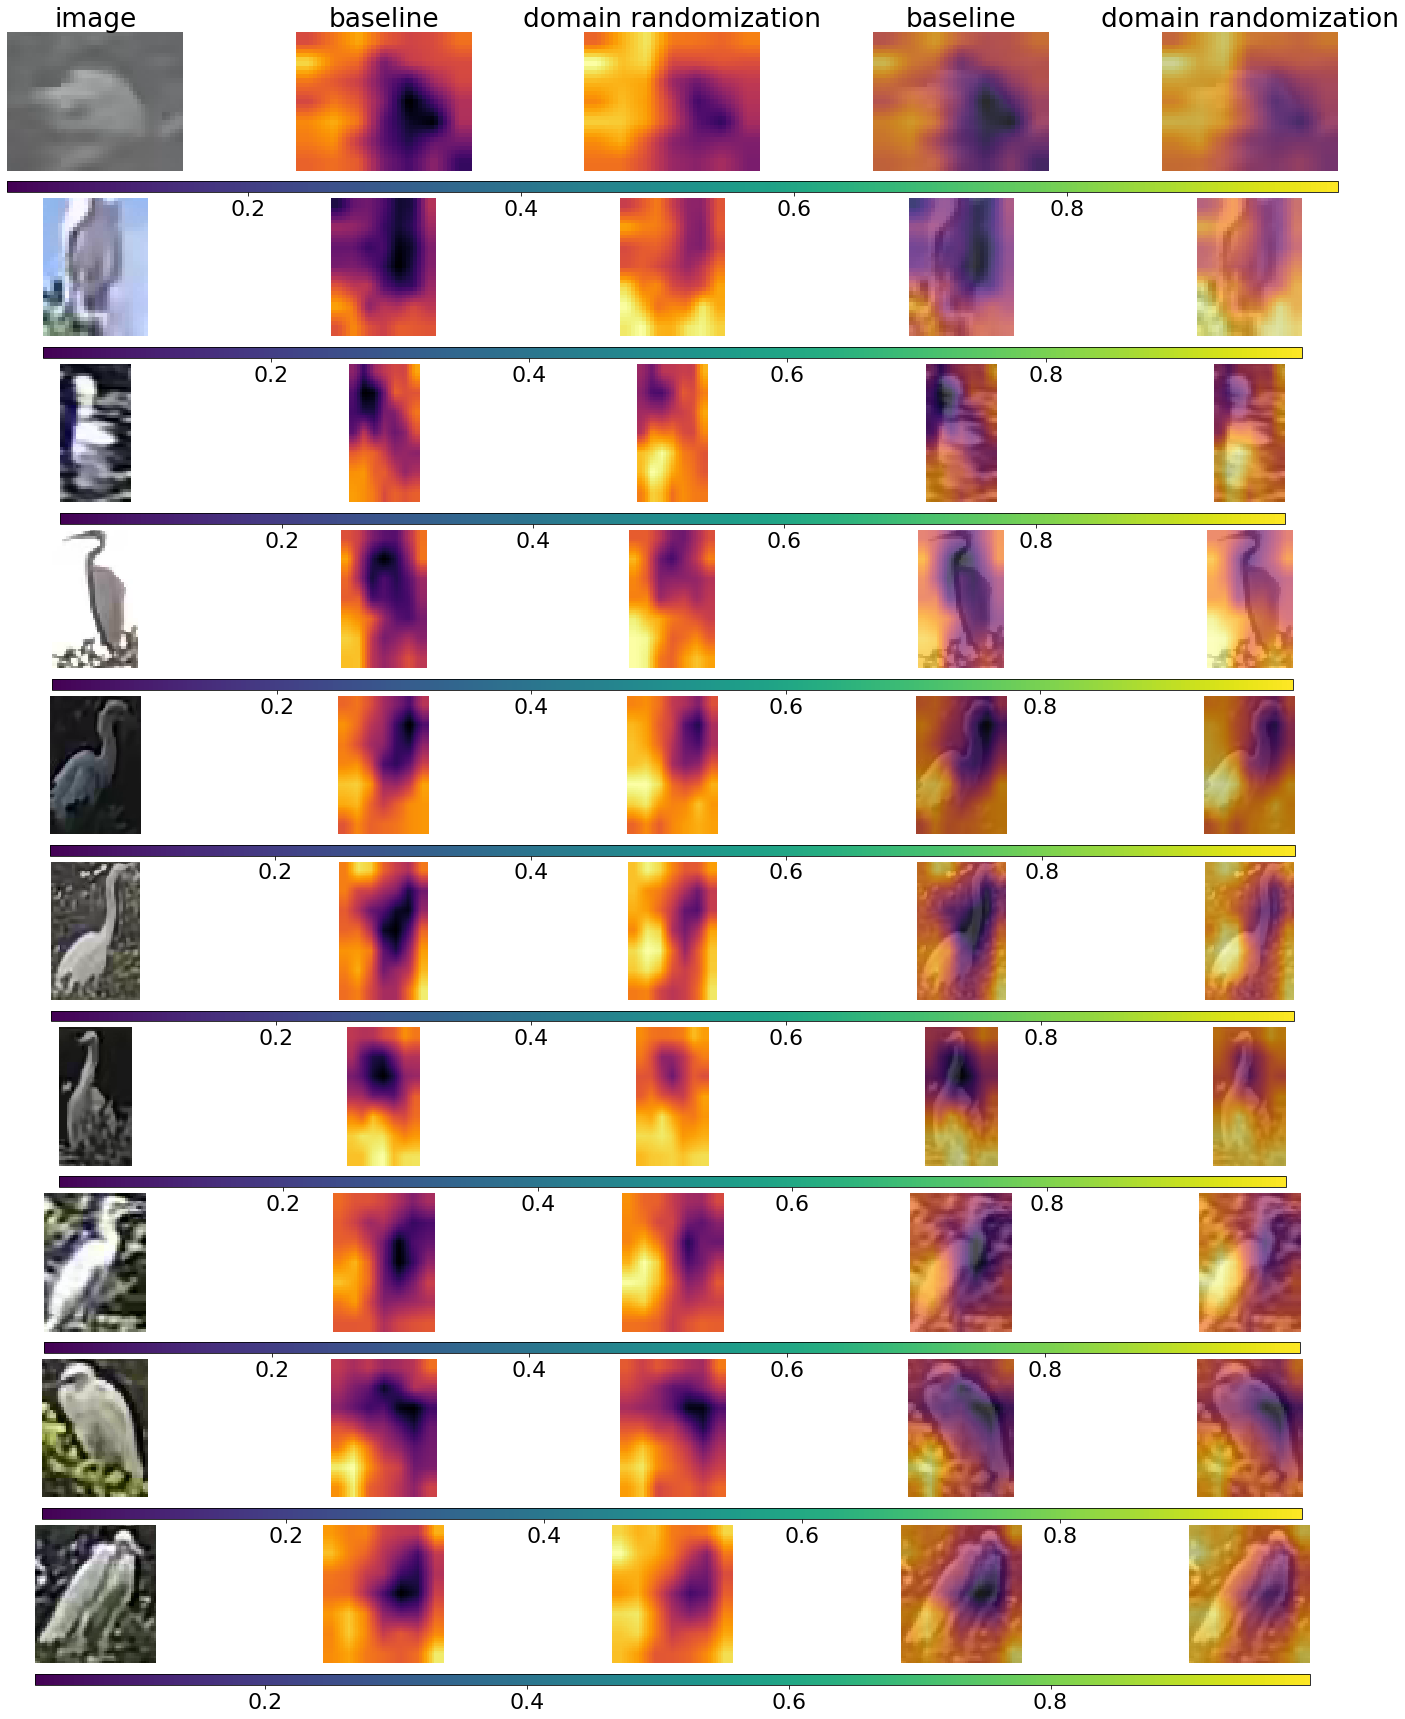

In [159]:
matplotlib.rcParams.update({'font.size': 22})
show(merged_imgs, merged_rows1, merged_rows2, cmap=plt.cm.inferno)